In [145]:
import numpy as np
from data_fns import noisy_sin_signal, data_matrix, butter_bandpass_filter
from estimator import RFClassifier, relu, sigmoid
import matplotlib.pyplot as plt

In [146]:
def bp_weights(M, N, lowcut, highcut, fs, seed=None):
    if seed is not None:
        np.random.seed(seed)
    J = np.random.randn(M, N)
    J = butter_bandpass_filter(J, lowcut, highcut, fs)
    return J.T

def forget_filter(t, gamma, f_s, t_memory):
    t_points = np.arange(t * f_s)
    n_memory = int(f_s * t_memory)
    f = np.minimum(1, gamma ** -(t_points - n_memory))
    return f[::-1].reshape(-1, 1)

In [157]:
# generate data
f_s = 2000
dur = 10
f_sig = 80
sig_dur = 0.05
a = 0.8

# neuron memory
delta = 0.1
N = int(delta * f_s)

signal, label = noisy_sin_signal(f_s=f_s, dur=dur, f_signal=f_sig, sig_dur=sig_dur, a=a, seed=39)
X, y = data_matrix(signal, label, N)

# separate into train and test
idx = int(len(X) * 2 / 3)
X_train, y_train = X[:idx], y[:idx]
X_test, y_test = X[idx:], y[idx:]

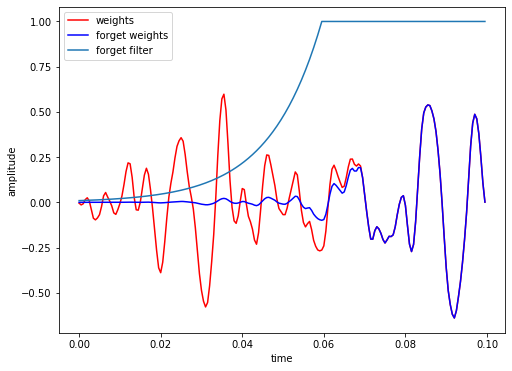

In [156]:
# visualize forgetting weights
weights = lambda M, N: bp_weights(M, N, 50, 120, f_s, seed=22)
f_weights = lambda M, N: weights(M, N) * forget_filter(delta, 1.05, f_s, 0.03)

n = 33
fig = plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, N) / f_s, weights(200, N).T[n], 'r', label='weights')
plt.plot(np.arange(0, N) / f_s, f_weights(200, N).T[n], 'b', label='forget weights')
plt.plot(np.arange(0, N) / f_s, forget_filter(delta, 1.04, f_s, 0.04), label='forget filter')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.legend()
plt.savefig('figures/forget_weights.png')

In [158]:
n_features = np.logspace(0, 4, 6, endpoint=False).astype('int')

In [159]:
# forgetting feature
weights = lambda M, N: bp_weights(M, N, 50, 120, f_s)
f_weights = lambda M, N: weights(M, N) * forget_filter(delta, 1.05, f_s, 0.02)

mean_err_f = []
std_err_f = []
for n in n_features:
    trial_err = []
    for __ in range(1):
        clf = RFClassifier(width=n, weights='forget bp', nonlinearity=relu, weight_fun=f_weights)
        clf.fit(X_train, y_train)
        trial_err.append(1 - clf.score(X_test, y_test))
    mean_err_f.append(np.mean(trial_err))
    std_err_f.append(np.std(trial_err))

/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

In [160]:
# without forgetting
mean_err = []
std_err = []
for n in n_features:
    trial_err = []
    for __ in range(1):
        clf = RFClassifier(width=n, weights='bp weights', nonlinearity=relu, weight_fun=weights)
        clf.fit(X_train, y_train)
        trial_err.append(1 - clf.score(X_test, y_test))
    mean_err.append(np.mean(trial_err))
    std_err.append(np.std(trial_err))

/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

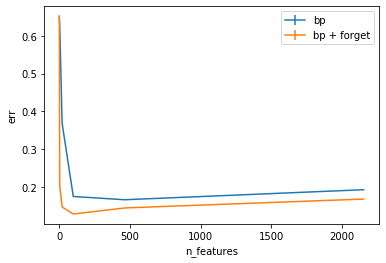

In [161]:
fig = plt.figure()
plt.errorbar(n_features, mean_err, yerr=std_err, label='bp')
plt.errorbar(n_features, mean_err_f, yerr=std_err_f, label='bp + forget')
plt.xlabel('n_features')
plt.ylabel('err')
plt.legend()

In [142]:
# effect of forgetting on performance
n_features = np.logspace(0, 4, 6, endpoint=False).astype('int')
sig_dur = 0.1
f_s = 2000
delta = 0.1
N = int(f_s * delta)

signal, label = noisy_sin_signal(f_s, dur=10, f_signal=80, sig_dur=sig_dur, a=1, seed=39)
X, y = data_matrix(signal, label, N)

# separate into train and test
idx = int(len(X) * 2 / 3)
X_train, y_train = X[:idx], y[:idx]
X_test, y_test = X[idx:], y[idx:]

# weights
weights = lambda M, N: bp_weights(M, N, 50, 120, f_s)
mem = [0, 0.02, 0.04, 0.06, 0.1]
err = {}
for t_mem in mem:
    f_weights = lambda M, N: weights(M, N) * forget_filter(delta, 1.05, f_s, t_mem)
    trial = []
    for n in n_features:
        clf = RFClassifier(width=n, weights='bp weights', nonlinearity=relu, weight_fun=weights)
        clf.fit(X_train, y_train)
        trial.append(1 - clf.score(X_test, y_test))
    err[t_mem] = trial

/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

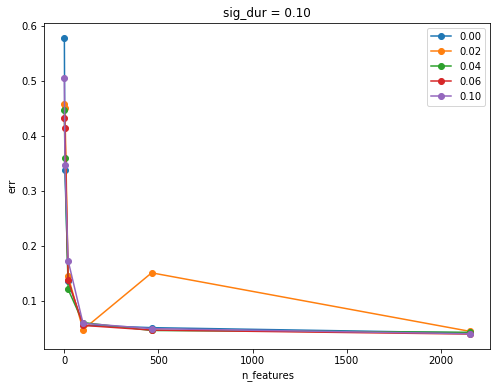

In [144]:
t = np.arange(0, delta + 0.02, 0.02)
fig = plt.figure(figsize=(8, 6))
plt.title('sig_dur = %0.2f' % sig_dur)
for t_mem, y in err.items():
    plt.plot(n_features, y, '-o', label='%0.2f' % t_mem)
plt.xlabel('n_features')
plt.ylabel('err')
plt.legend()
plt.savefig('figures/forget_weights_%0.2f sigdur.png' % sig_dur)